We start by interpolating the thermophysical properties of the solid:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
T = np.array([20, 100, 200, 300, 400]) + 273.15
k_s = np.array([147, 155, 159, 159, 155])
c = np.array([739, 755, 797, 838, 922])

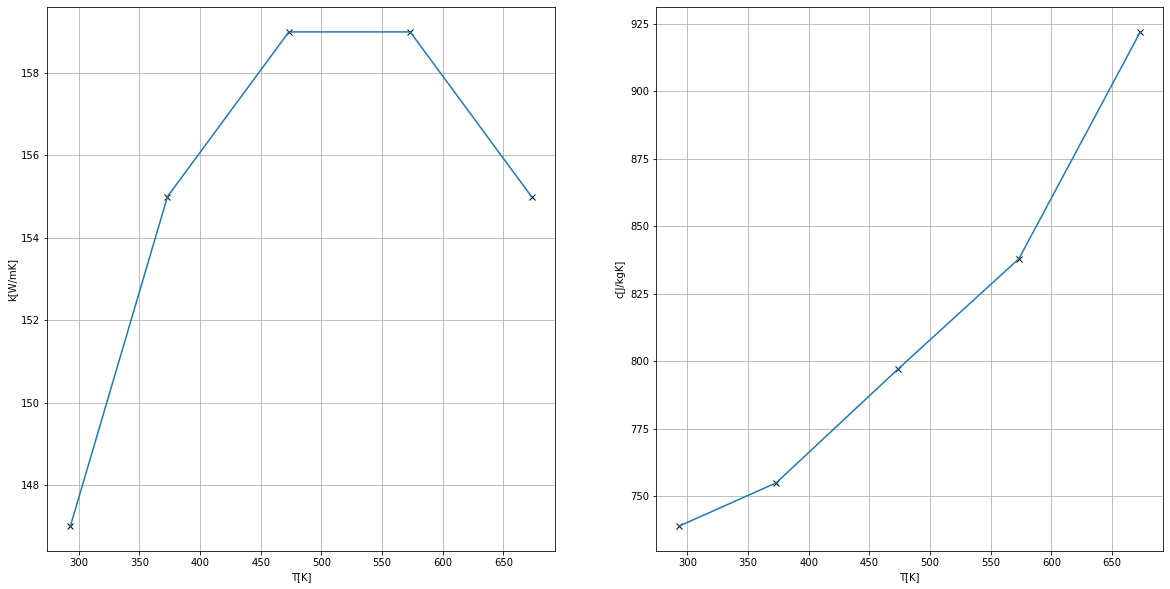

In [3]:
k_interpolate = scipy.interpolate.CubicSpline(T, k_s)
c_interpolate = scipy.interpolate.CubicSpline(T, c)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

ax1.plot(T, k_s, 'kx')
ax1.plot(T, k_interpolate(T))
ax1.set_xlabel('T[K]')
ax1.set_ylabel('k[W/mK]')
ax1.grid()

ax2.plot(T, c, 'kx')
ax2.plot(T, c_interpolate(T))
ax2.set_xlabel('T[K]')
ax2.set_ylabel('c[J/kgK]')
ax2.grid()

Defining the geometry of the powderbed:

In [4]:
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(12345)

x = 1.54e-3
y = 0.7e-3
z = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x, y, z))

Set the default float type to float64


Defining the time and the domian:

In [5]:
t = 0.005

time = dde.geometry.TimeDomain(0.0, t)
domain = dde.geometry.GeometryXTime(geo, time)

Defining the other properties:

In [6]:
rho = 2650.0
A = 0.09
D = 70e-6
R = D/2
P = 250
v = 200e-3

Defining the top boundary neglecting the convection and radiation:

In [7]:
def top_bc(X):
    
    r_sq = (X[:,0] - x/4 - X[:,3]*v)**2 + (X[:,1] - y/2)**2
    
    return 2*A*P/(np.pi*R**2)*np.exp(-2*r_sq/R**2)

Plotting the end position of teh laser beam on the surface

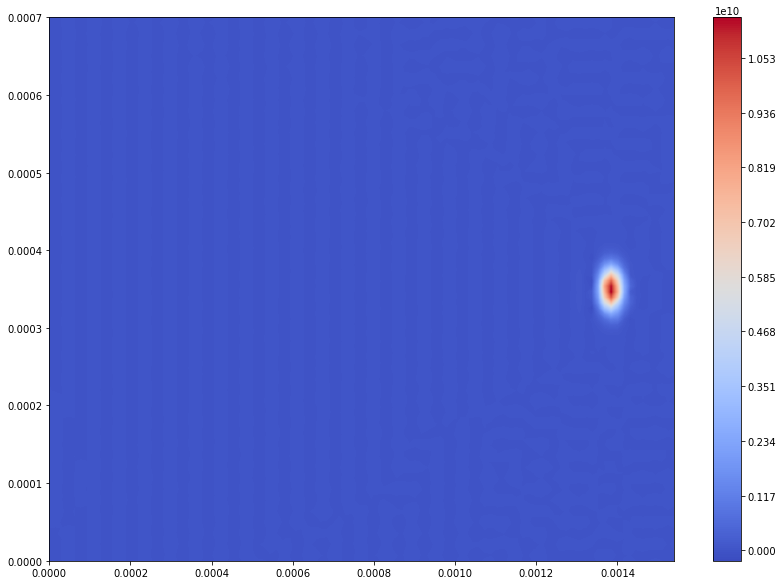

In [8]:
from scipy.interpolate import griddata

x_lin = np.linspace(0, x)
y_lin = np.linspace(0, y)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z], [0.005])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), top_bc(X), (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 1000, cmap=plt.cm.coolwarm)
plt.colorbar()

defining the pde system:

In [9]:
def pde_system(X, output):#
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
    
    #k_eff = k_interpolate(T)
    #c_eff = c_interpolate(T)
    
    k_eff = 155
    c_eff = 922
    
    diff_T = k_eff*dde.grad.jacobian(dT_dx, X, j = 0) + k_eff*dde.grad.jacobian(dT_dy, X, j=1) + k_eff*dde.grad.jacobian(dT_dz, X, j = 2)
    
    f_T = rho*c_eff*dT_dt - diff_T
    
    return f_T

def dummy(X, output):
    return output

Defining initial and boundary conditions:

In [10]:
def top_bc_new(X):
    
    r_sq = (X[:,0:1] - x/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y/2)**2
    
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)

ic = dde.icbc.IC(domain, lambda on_initial: 20 + 273.15, lambda _, on_initial: on_initial)
#top = dde.icbc.NeumannBC(domain, top_bc(x), lambda on_boundary, x: on_boundary and np.isclose(x[2], z))
top = dde.icbc.RobinBC(domain, lambda X, y : top_bc_new(X)/155, lambda x, on_boundary: on_boundary and np.isclose(x[2], z, atol=z/10))
sides = dde.icbc.DirichletBC(domain, lambda X : 20 + 273.15, lambda x, on_boundary: on_boundary and not np.isclose(x[2], z, atol=z/10))

creating the dataset:

In [11]:
time = dde.geometry.TimeDomain(0.0, t)
domain = dde.geometry.GeometryXTime(geo, time)

data = dde.data.TimePDE(domain,
                        pde_system,
                       ic_bcs=[ic, top, sides],
                       num_domain=100,
                       num_initial=100,
                       num_boundary = 1000,
                       num_test=100)

/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "
/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1002=1002. 
  warnings.warn("The balance properties of Sobol' points require "


In [12]:
#net = dde.nn.FNN([4] + [20] * 8 + [1], "sin", "Glorot normal")
net = dde.nn.MsFFN([4] + [40] * 6 + [4], "sin", "Glorot normal", sigmas = [1e-1, 1])

def feature_transform(X):
    return tf.concat(
        [X[:, 0:1]/x, 
         X[:, 1:2]/y,
         X[:, 2:3]/z,
        X[:, 3:4]/t], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = Temperature*1000 + 20 + 373.15
    return T_new
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(epochs=0, display_every=1000)

/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Compiling model...
Building Multiscale Fourier Feature Network...


2022-05-21 10:07:29.625339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 10:07:29.662680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 10:07:29.663220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 10:07:29.665017: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the 

'compile' took 5.268531 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.00e+26, 2.15e+05, 2.55e+13, 2.06e+05]    [5.91e+25, 2.15e+05, 2.55e+13, 2.06e+05]    []  

Best model at step 0:
  train loss: 1.00e+26
  test loss: 5.91e+25
  test metric: []

'train' took 1.564899 s



In [13]:
weights = 1/np.array(losshistory.loss_train[0])
model.compile("adam", lr=1e-3, loss_weights=weights)
losshistory, train_state = model.train(epochs=10000, display_every=1000)

Compiling model...
'compile' took 3.357259 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.49e+00, 9.64e-01, 1.34e+00, 6.65e-01]    [2.49e+00, 9.64e-01, 1.34e+00, 6.65e-01]    []  
1000      [4.21e-03, 1.37e-04, 1.39e-02, 4.39e-04]    [5.12e-02, 1.37e-04, 1.39e-02, 4.39e-04]    []  
2000      [1.44e-03, 7.62e-05, 8.05e-03, 1.41e-04]    [2.18e-02, 7.62e-05, 8.05e-03, 1.41e-04]    []  
3000      [1.06e-02, 1.72e-03, 4.61e-03, 1.44e-03]    [2.96e-02, 1.72e-03, 4.61e-03, 1.44e-03]    []  
4000      [6.31e-04, 7.48e-05, 7.03e-04, 8.89e-05]    [6.64e-02, 7.48e-05, 7.03e-04, 8.89e-05]    []  
5000      [1.71e-03, 2.24e-05, 1.71e-04, 4.76e-05]    [5.60e-02, 2.24e-05, 1.71e-04, 4.76e-05]    []  
6000      [1.92e-04, 1.04e-05, 7.74e-05, 3.00e-05]    [4.69e-02, 1.04e-05, 7.74e-05, 3.00e-05]    []  
7000      [2.66e-04, 3.88e-05, 5.47e-05, 5.27e-05]    [4.30e-02, 3.88e-05, 5.4

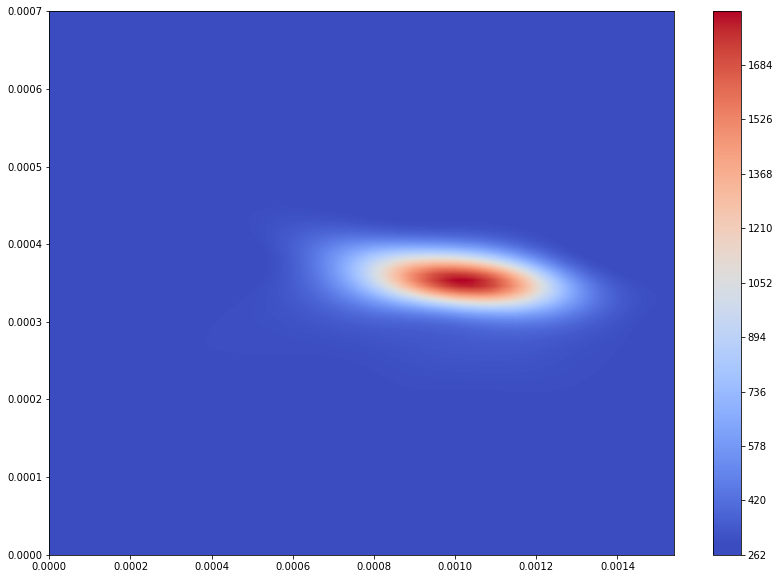

In [21]:
x_lin = np.linspace(0, x)
y_lin = np.linspace(0, y)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z], [0.9*t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 1000, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

In [15]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 3.170843 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
10000     [2.02e-04, 6.73e-06, 2.25e-05, 1.25e-05]    [3.82e-02, 6.73e-06, 2.25e-05, 1.25e-05]    []  
10100     [4.14e-05, 3.57e-06, 1.01e-05, 7.43e-06]                                                    
10200     [2.60e-05, 2.30e-06, 6.41e-06, 4.83e-06]                                                    
10300     [1.84e-05, 1.74e-06, 4.72e-06, 3.30e-06]                                                    
10400     [1.34e-05, 1.33e-06, 3.45e-06, 2.71e-06]                                                    
10500     [1.02e-05, 1.01e-06, 2.63e-06, 2.29e-06]                                                    
10600     [8.17e-06, 8.04e-07, 2.05e-06, 1.96e-06]                                                    
10700     [6.66e-06, 5.96e-07, 1.85e-06, 1.60e-06]                                                    
1